In [1]:
%matplotlib widget

import ipywidgets as widgets
from ipywidgets import HBox, VBox, jslink, Box
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
from scipy.integrate import solve_ivp

from exampleData.utils import TikzImage

# Stabilitätsanalyse für Ruhelagen

## Pendel

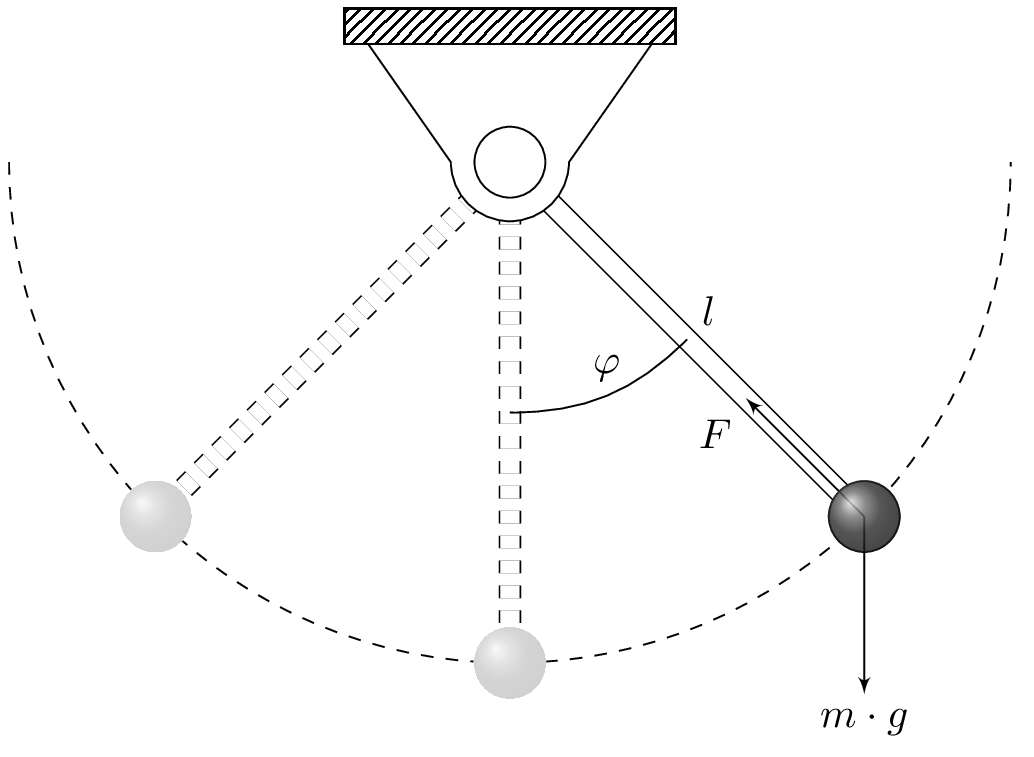

In [2]:
Image(data=TikzImage(tikzFile='../tex/tikz/pendulum.tex').getImageData(), width=600)

### Mathematische Beschreibung
- __mathematisches Pendel__ mit Dämpfung $k$ in Aufhängung
- nichtlineares Modell
  \begin{align*}
      m\, l^2\ddot{\varphi}(t) + k \dot{\varphi}(t) + m\,g\, l \sin(\varphi(t)) & = 0, & \varphi(0) & = \varphi_0, & \dot{\varphi}(0) & = \dot{\varphi}_0
  \end{align*}
- Ruhelagen nichtlineares Modell
  \begin{align*}
      \sin(\bar{\varphi}(t)) & = 0 & \bar{\varphi}_i & = i \pi, & i & = 0, 1, 2, \ldots
  \end{align*}
- linearisiertes Modell mit $\tilde{\varphi} = \varphi - \bar{\varphi}$
  \begin{align*}
      \ddot{\tilde{\varphi}}(t) + \frac{k}{m\, l^2} \dot{\tilde{\varphi}}(t) + \frac{g}{l} \varphi(t) & = 0
  \end{align*}
- Zustandsdarstellung mit $x_1 = \tilde{\varphi}$, $x_2 = \dot{\tilde{\varphi}}$
  \begin{align*}
      \begin{pmatrix}\dot{x}_1(t)\\\dot{x}_2(t) \end{pmatrix} & = \underbrace{\begin{pmatrix} 0 & 1\\ -\frac{g}{l} & -\frac{k}{m\, l^2}\end{pmatrix}}_{\boldsymbol{A}} \begin{pmatrix} x_1(t) \\  x_2(t)\end{pmatrix}, & \begin{pmatrix} x_1(0) \\  x_2(0)\end{pmatrix} & = \begin{pmatrix} x_{10} \\  x_{20}\end{pmatrix}
  \end{align*}
- Ruhelagen linearisiertes Modell aus Matrix $\boldsymbol{A}$ mit $\det(\boldsymbol{A}) = \frac{g}{l} \neq 0$


### Simulation

In [3]:
def make_box_layout():
     return widgets.Layout(
        border='solid 1px black',
        margin='0px 10px 10px 0px',
        padding='5px 5px 5px 5px'
     )

In [4]:
l = 1
m = 1
g = 9.81

In [5]:
tSim = np.linspace(0, 10, 1001)


x0 = [0, 0.]
k0 = 0

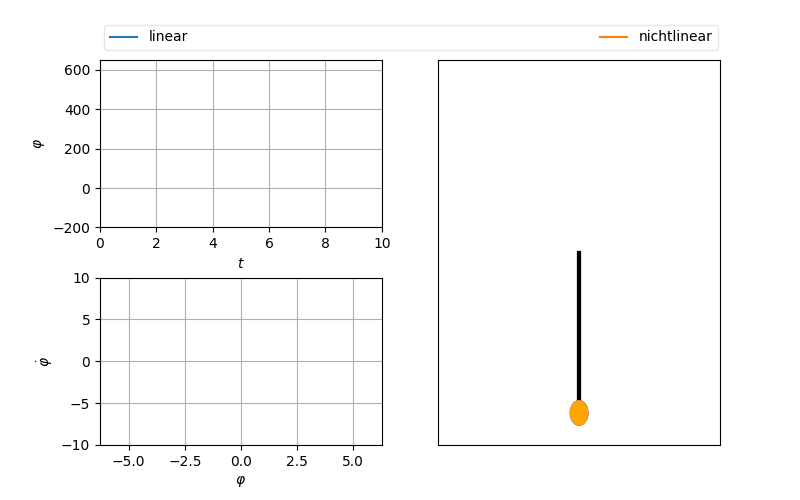

In [7]:
output = widgets.Output()

with output:
    fig = plt.figure(figsize=(8, 5))
    ax3 = plt.subplot(122)
    ax1 = plt.subplot(221)
    ax2 = plt.subplot(223)

plt.subplots_adjust(wspace=0.2, hspace=0.3)
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False

ax1.set_xlim([0, tSim[-1]]) 
ax1.set_ylim([-200, 650]) 
ax2.set_xlim([-2*np.pi, 2*np.pi]) 
ax2.set_ylim([-10, 10]) 
ax1.grid() 
ax2.grid()
ax3.set_xlim(-l * 1.2, l * 1.2)
ax3.set_ylim(-l * 1.2, l * 1.2)
ax3.set_xticks([])
ax3.set_yticks([])
ax1.set_xlabel(r"$t$")
ax1.set_ylabel(r"$\varphi$")
ax2.set_xlabel(r"$\varphi$")
ax2.set_ylabel(r"$\dot{\varphi}$")

lineLinSys, = ax1.plot([], [], label='linear')
lineLinTraj, = ax2.plot([], [])
lineNlSys, = ax1.plot([], [], label='nichtlinear')
lineNlTraj, = ax2.plot([], [])

lineAniLin, = ax3.plot([0, l * np.sin(x0[0])], [0, -l * np.cos(x0[0])], lw=3, c='k')
circleAniLin = ax3.add_patch(plt.Circle((l * np.sin(x0[0]), -l * np.cos(x0[0])), 0.08, fc='blue', zorder=3))
lineAniNl, = ax3.plot([0, l * np.sin(x0[0])], [0, -l * np.cos(x0[0])], lw=3, c='k', alpha=0.5)
circleAniNl = ax3.add_patch(plt.Circle((l * np.sin(x0[0]), -l * np.cos(x0[0])), 0.08, fc='orange', zorder=3))

handlesAx, labelsAx = ax1.get_legend_handles_labels()
fig.legend([handle for i, handle in enumerate(handlesAx)],
           [label for i, label in enumerate(labelsAx)],
           bbox_to_anchor=(0.13, 0.9, 0.7675, .15), loc=3,
           ncol=2, mode="expand", borderaxespad=0., framealpha=0.5)

playB = widgets.Play(value=0,
                     min=0, 
                     max=len(tSim),
                     step=10)
sliderB = widgets.IntSlider(value=0,
                            min=0,
                            max=len(tSim),
                            step=10)
sliderK = widgets.FloatSlider(value=k0,
                              min=-1,
                              max=1,
                              step=0.25,
                              description='k')
sliderX00 = widgets.FloatSlider(value=x0[0],
                                min=-np.pi,
                                max=np.pi,
                                step=np.pi / 4,
                                description='x00')
sliderX01 = widgets.FloatSlider(value=x0[1],
                                min=-1,
                                max=1,
                                step=0.1,
                                description='x01')
                                         
def updateLinOde(_):
    k = sliderK.value
    x0 = [sliderX00.value, sliderX01.value]
    global resLin
    
    def linPendel(t, x, k):
        dx = np.zeros(2)
        dx[0] = x[1]
        dx[1] = - g / l * x[0] - k / (m * l ** 2) * x[1]

        return dx
    
    resLin = solve_ivp(linPendel,
                       [tSim[0], tSim[-1]],
                       x0,
                       t_eval=tSim, args=(k, ))

def updateNlOde(_):
    k = sliderK.value
    x0 = [sliderX00.value, sliderX01.value]
    global resNl

    def nlPendel(t, x, k):
        dx = np.zeros(2)
        dx[0] = x[1]
        dx[1] = - g / l * np.sin(x[0]) - k / (m * l ** 2) * x[1]

        return dx
    
    resNl = solve_ivp(nlPendel,
                      [tSim[0], tSim[-1]],
                      x0,
                      t_eval=tSim, args=(k, ))

def updatePlot(change):
    idx = change['new']
    lineLinSys.set_data(tSim[:idx], np.rad2deg(resLin.y.T[:idx, 0]))
    lineNlSys.set_data(tSim[:idx], np.rad2deg(resNl.y.T[:idx, 0]))
    lineLinTraj.set_data(resLin.y.T[:idx, 0], resLin.y.T[:idx, 1])
    lineNlTraj.set_data(resNl.y.T[:idx, 0], resNl.y.T[:idx, 1])
    
    phiLin = resLin.y.T[idx, 0]
    xLin = l * np.sin(phiLin)
    yLin = -l * np.cos(phiLin)
    lineAniLin.set_data([0, xLin], [0, yLin])
    circleAniLin.set_center((xLin, yLin))

    phiNl = resNl.y.T[idx, 0]
    xNl = l * np.sin(phiNl)
    yNl = -l * np.cos(phiNl)
    lineAniNl.set_data([0, xNl], [0, yNl])
    circleAniNl.set_center((xNl, yNl))

    fig.canvas.draw()    

sliderB.observe(updatePlot, names='value')
sliderK.observe(updateNlOde, names='value')
sliderK.observe(updateLinOde, names='value')
sliderX00.observe(updateNlOde)
sliderX00.observe(updateLinOde)
sliderX01.observe(updateNlOde)
sliderX01.observe(updateLinOde)

updateNlOde(_)
updateLinOde(_)

odeControls = VBox([sliderK, sliderX00, sliderX01])
odeControls.layout = make_box_layout()
jslink((playB, 'value'), (sliderB, 'value'))
videoControls = VBox([HBox([playB, sliderB]), output])
videoControls.layout = make_box_layout()

HBox([odeControls, Box([videoControls])])